\setcounter{secnumdepth}{0}

# Assignment 3 - Stochastic Processes

    Name: Clara Periago
    Student #: s1067476

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr

# Exercise 1 - Lorentz system

Simulate the following Lorenz system:

$$\dot{x} = \sigma (y - x)$$
$$\dot{y} = \rho x - y - xz$$
$$\dot{z} = xy - \beta (z)$$

with $\sigma = 10$, 
$\rho = 28$, 
$\beta = 8/3$

## Exercise 1.1

Reconstruct the Lorenz attractor in figure 44 (dynamical systems theory), by integrating the system for an initial condition of choice with a sufficiently low step size (note: this might be very small!). Make use of a solver of your choice from last week's assignment.

In [2]:
# these are copy pasted from the last exercise
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

# helper wrapper that takes a step solver, initial conditions and time domain
def simulate(solver, c0, t):
    def iterate(c, t):
        xn1 = solver(c, t)
        return xn1, xn1
    
    _, xs = jax.lax.scan(iterate, c0, t)
    return xs

# only thing we need to change is this function to represent the dynamics
def lorentz(sigma=10., rho=28., beta=8./3.): # attractor written as matrix
    def _wrap(t, c):
        x, y, z = c
        return jnp.array([sigma * (y - x), rho * x - y - x *z, x * y - beta * z])
    return _wrap

ERROR:2025-09-17 17:57:22,484:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CU

Text(0.5, 0.92, 'Lorenz Attractor')

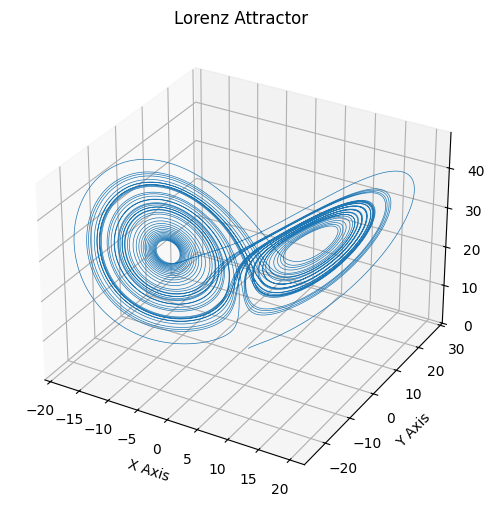

In [3]:
dt = 0.001
t = jnp.arange(0, 50, dt)

lor_attr = lorentz() # instance of our f(*x, t) system
solver = rk4(lor_attr, dt) # solver function for our system & dt
xyz0 = jnp.array([1., 1., 1.]) # initial state
xyzs = simulate(solver, xyz0, t) # iterate over the t space

ax = plt.figure(figsize=(12, 6)).add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

## Exercise 1.2

Simulate the trajectories for 100 initial conditions, all of which are minor (random) deviations from the initial condition you used in part a.  Visualize the solution trajectories as a function of time. What happens to the trajectories as time increases?  

(100, 50000, 3)


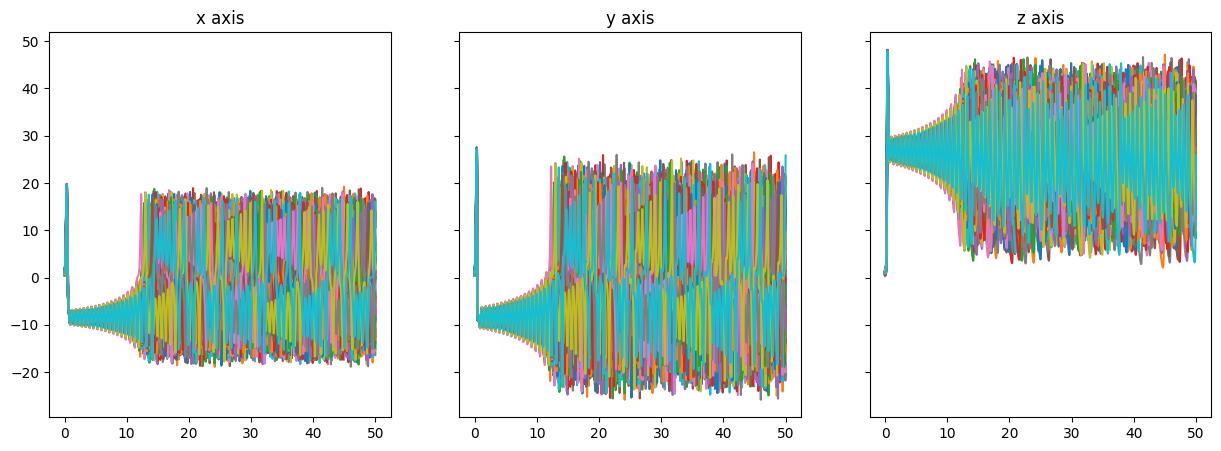

In [4]:
perturb_size = 0.3

N = 100
key = jr.PRNGKey(42)
keys = jr.split(key, N)

def single_run(key):
    xyz0_prime = xyz0 + perturb_size * jr.normal(key, 3)
    xyzs = simulate(solver, xyz0_prime, t) # iterate over the t space
    return xyzs

xyzs = jax.vmap(single_run)(keys)

print(xyzs.shape)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axs):
    xx = xyzs[:, :, i]
    # print(xx.shape)
    for j in range(xx.shape[0]):
        ax.plot(t, xx[j])
    ax.set_title(f"{'xyz'[i]} axis")


# Exercise 2: 2D Brownian motion

Create a simulation of Brownian motion of a particle in two dimensions (slide 40 of stochastic processes).

In [5]:
jnp.array([jnp.array([1,2,3]), jnp.array([4,5,6])])

Array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

(50000, 2, 2)
(50000, 2)


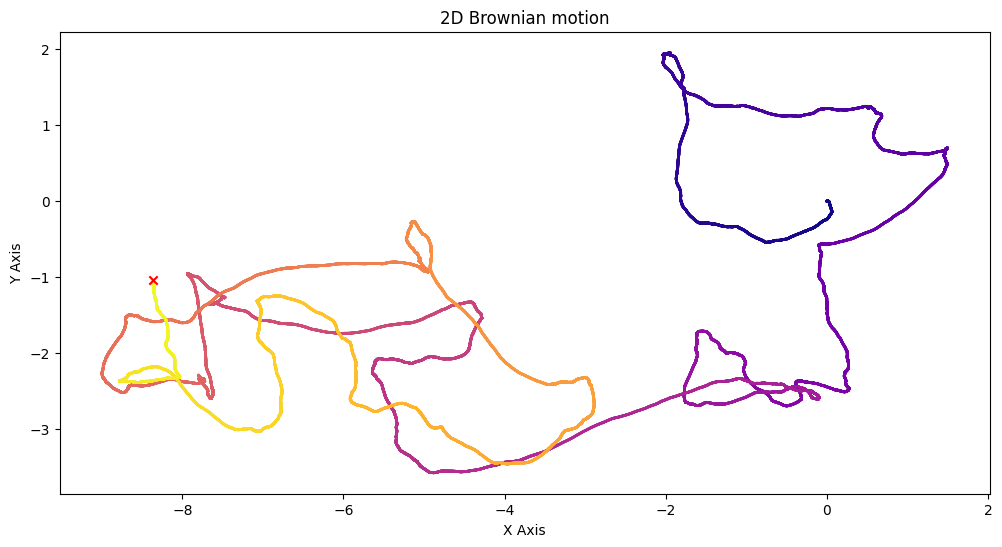

In [6]:
def euler_maruyama(f, dt): # this is just boilerplate but we can't just use the euler fn from before. since we need also dt here
    @jax.jit
    def step(c, t):
        return f(t, c, dt)
    return step

# only thing we need to change is this function to represent the dynamics
def brownian(mass=1., D=1., gamma=1.): # attractor written as matrix
    sigma = jnp.sqrt(2 * mass ** -2 * D)
    _lambda = gamma / mass
    def _wrap(t, c, dt):
        (x, v), key = c # here x and v are each 2d vectors!

        key, subkey = jr.split(key)
        epsilon = jr.normal(subkey, 2)
        # jax.debug.print("{vs}", vs=v.shape)
        delta = jnp.array([
            x + v * dt,
            v - dt * v * _lambda + jnp.sqrt(dt) * sigma * epsilon
        ])
        return delta, subkey
    return _wrap

brown = brownian(gamma=1, D=1.) # instance of our f(*x, t) system
brown_solver = euler_maruyama(brown, dt) # solver function for our system & dt
xy0 = jnp.array([[0., 0.], [0., 0.]]) # initial state
xvs, _ = simulate(brown_solver, (xy0, key), t) # iterate over the t space

print(xvs.shape) # should correspond to (T, V_P, XY) where V_P are velocity & positions stacked



fig, ax = plt.subplots(figsize=(12, 6))

xs = xvs[:, 0, :] # discard velocity

print(xs.shape)

colors = plt.cm.plasma(jnp.linspace(0, 1, len(xs)))
ax.scatter(*xs.T, c=colors, s=1)
ax.scatter(*xs[-1], c='red', marker='x', label='end')
ax.set_title("2D Brownian motion")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis");

(50000, 2)


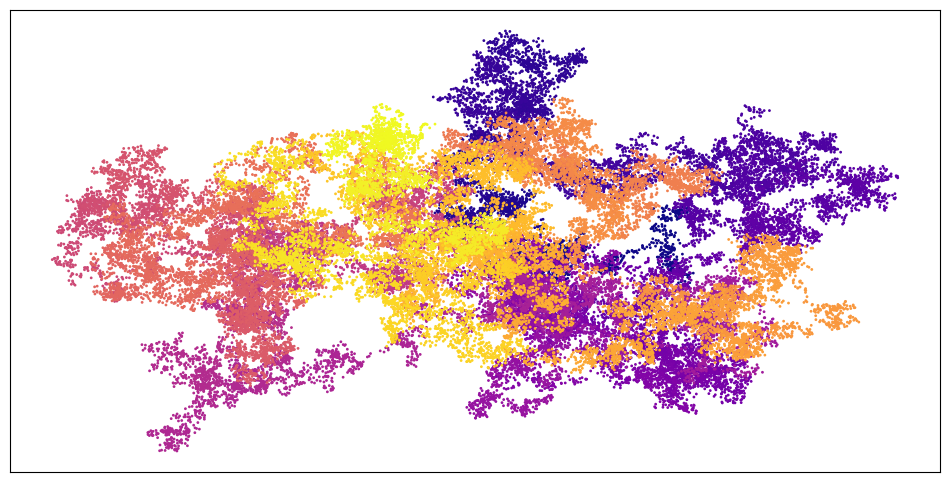

In [7]:
# extra plot because it's pretty ^^

# i like how these parameters look on the v-plot
brown = brownian(gamma=0.05, D=3.) # instance of our f(*x, t) system
brown_solver = euler_maruyama(brown, dt) # solver function for our system & dt
xy0 = jnp.array([[0., 0.], [0., 0.]]) # initial state
xvs, _ = simulate(brown_solver, (xy0, key), t)

fig, ax = plt.subplots(figsize=(12, 6))

vs = xvs[:, 1, :] # here we select velocity because it looks like clouds

print(vs.shape)

colors = plt.cm.plasma(jnp.linspace(0, 1, len(vs)))
ax.scatter(*vs.T, c=colors, s=1)
ax.set_xticks([])
ax.set_yticks([]);

# Exercise 3 - Fixed points

Derive the fixed points of the pendulum from its state equation:
\begin{equation}
\dot{x} 
=  \begin{bmatrix} x_2 \\   - \omega_0^2 \sin(x_1) - \gamma x_2 \end{bmatrix} 
\end{equation}

To find the fixed points, we examine where the gradient ($\dot{x}$) is zero. We do this for each case, $x_2$ and then $x_1$:

\begin{align*}
\dot{x} &=  \begin{bmatrix} x_2 \\   - \omega_0^2 \sin(x_1) - \gamma x_2 \end{bmatrix} = 0 \rightarrow \\
x_2 &= 0 && x_2 \text{will always be zero in our fixed points} \\
- \omega_0^2 \sin(x_1) - \gamma x_2 &= 0 && \text{we can replace any mention of } x_2 \text{ with 0} \\
\sin(x_1) &= 0 && \text{we get rid of constants, and now we just solve for } x_1 \\
x_1 &= n \pi, \quad n \in \mathbb{Z} && \text{any integer multiple of pi will make the sine be zero}
\end{align*}

So we end up with infinite fixed points (theoretically), at $x^* = (n\pi, 0)$. Note that the infinite points are only theoretically, since all even values of $n$ will be the same as $n=0$, corresponding to a stable point where the pendulum is at the bottom (resting position). And for all odd values of $n$, the point is the same as $n=1$, meaning the pendulum resting in equilibrium at half a rotation (180º), in a saddle point.